In [ ]:
!pip install medmnist

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F


import medmnist
from medmnist import INFO, Evaluator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

This is 1. notebook for OCTMNIST Dataset (1 canal)<br>
4 clases <br>train: 97477<br>val: 10832<br>test: 1000


In [ ]:
#selecting device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


#Loading dataset

In [ ]:
data_flag = 'octmnist'
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 100
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5],),
    # transforms.Grayscale(num_output_channels=1)
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader_at_eval = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

  0%|          | 0/54938180 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


#Info + samples

In [ ]:
info

{'python_class': 'OCTMNIST',
 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/octmnist.npz?download=1',
 'MD5': 'c68d92d5b585d8d81f7112f81e2d0842',
 'task': 'multi-class',
 'label': {'0': 'choroidal neovascularization',
  '1': 'diabetic macular edema',
  '2': 'drusen',
  '3': 'normal'},
 'n_channels': 1,
 'n_samples': {'train': 97477, 'val': 10832, 'test': 1000},
 'license': 'CC BY 4.0'}

In [ ]:
label_array_train = []
for (data, labels) in train_dataset:
  label_array_train.append(labels)
index_values = np.arange(1, len(label_array_train)+1)
column_values = ['class']
  
# creating the train dataframe
df_train = pd.DataFrame(data = label_array_train, 
                  index = index_values, 
                  columns = column_values)

label_array_val = []
for (data, labels) in val_dataset:
  label_array_val.append(labels)
index_values = np.arange(1, len(label_array_val)+1)
column_values = ['class']
  
# creating the val dataframe
df_val = pd.DataFrame(data = label_array_val, 
                  index = index_values, 
                  columns = column_values)

label_array_test = []
for (data, labels) in test_dataset:
  label_array_test.append(labels)
index_values = np.arange(1, len(label_array_test)+1)
column_values = ['class']
  
# creating the test dataframe
df_test = pd.DataFrame(data = label_array_test, 
                  index = index_values, 
                  columns = column_values)

In [ ]:
train_size_arange = np.arange(1, len(label_array_train)+1)
train_1 = sum(df_train["class"]==1)
train_0 = sum(df_train["class"]==0)
train_2 = sum(df_train["class"]==2)
train_3 = sum(df_train["class"]==3)

val_size_arange = np.arange(1, len(label_array_val)+1)
val_1 = sum(df_val["class"]==1)
val_0 = sum(df_val["class"]==0)
val_2 = sum(df_val["class"]==2)
val_3 = sum(df_val["class"]==3)

test_size_arange = np.arange(1, len(label_array_test)+1)
test_1 = sum(df_test["class"]==1)
test_0 = sum(df_test["class"]==0)
test_2 = sum(df_test["class"]==2)
test_3 = sum(df_test["class"]==3)

In [ ]:
import plotly.graph_objects as go
sets=['Train Dataset', 'Val Dataset', 'Test Dataset']
fig = go.Figure(data=[
    go.Bar(name='choroidal neovascularization', x=sets, y=[train_0, val_0, test_0]),
    go.Bar(name='diabetic macular edema', x=sets, y=[train_1, val_1, test_1]),
    go.Bar(name='drusen', x=sets, y=[train_2, val_2, test_2]),
    go.Bar(name='normal', x=sets, y=[train_3, val_3, test_3])
    ]
    )
fig.update_layout(title="Quantity of samples over sets", width=600, height=300,
                  margin=dict(l=00, r=20, b=30, t=40, pad=10),
                  legend=dict(yanchor="top",xanchor="right"))

fig.update_yaxes(title_text='Quantity')
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

100%|██████████| 97477/97477 [00:20<00:00, 4657.57it/s]


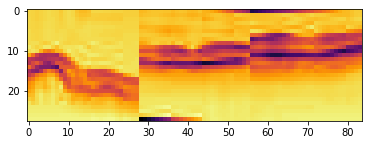

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
tr_l = np.array(train_dataset)
tr_l.shape
data_frame = pd.DataFrame()
img = []
for inputs, targets in tqdm(train_dataset):
  img.append(inputs)
  
sample_pics = [img]
pic1 = img[0].reshape(28,-1)
pic2 = img[1].reshape(28,-1)
pic3 = img[2].reshape(28,-1)
plt.imshow(np.hstack((pic1,pic2, pic3)), cmap="inferno_r")

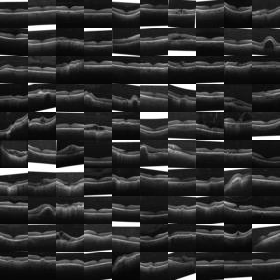

In [ ]:
#or using montage
train_dataset.montage(length=10)

**1) Real OCT of iris**

<img src="https://drive.google.com/uc?export=view&id=1wdjFPgPLHAHHH4AcRc4tv4opC5bBtuIK" width=450></img>

#Training and testing

In [ ]:
# model class for pneumonia prediction
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv1_bn=nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.conv2_bn=nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv3_bn=nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, 1)
        self.conv4_bn=nn.BatchNorm2d(128)

        # self.conv5 = nn.Conv2d(128, 180, 3, 1)
        # self.conv5_bn=nn.BatchNorm2d(180)

        self.fc1 = nn.Linear(7*7*128, 800) #((((28-2)/2)-2)/2) = 5,..
        self.fc1_bn=nn.BatchNorm1d(800)

        self.fc2 = nn.Linear(800, 300)
        self.fc2_bn=nn.BatchNorm1d(300)

        self.fc3 = nn.Linear(300, 60)
        self.fc3_bn=nn.BatchNorm1d(60)

        self.fc4 = nn.Linear(60, 2)


    def forward(self, X):
        X = self.conv1(X)
        X = F.relu(self.conv1_bn(X))  #1

        X = F.max_pool2d(X, 2, 2)

        X = self.conv2(X)
        X = F.relu(self.conv2_bn(X))

        X = self.conv3(X)
        X = F.relu(self.conv3_bn(X))  #3

        X = self.conv4(X)
        X = F.relu(self.conv4_bn(X))  #4

        # X = self.conv5(X)
        # X = F.relu(self.conv5_bn(X))  #4

        X = X.view(-1, 7*7*128)

        X = self.fc1(X)
        X = F.relu(self.fc1_bn(X))
        X = self.fc2(X)
        X = F.relu(self.fc2_bn(X))
        X = self.fc3(X)
        X = F.relu(self.fc3_bn(X))
        X = self.fc4(X)
        return F.sigmoid(X) #for binary class.
        #softmax(X, dim=1)

In [ ]:
model = ConvolutionalNetwork().to(device)
loss_function = nn.BCELoss() #for binary class.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6272, out_features=800, bias=True)
  (fc1_bn): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=800, out_features=300, bias=True)
  (fc2_bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=300, out_features=

In [ ]:
def get_accuracy(model, test_loader):
  correct = 0
  total = 0
  with torch.no_grad():
      for (data, labels) in test_loader:
          net_out = model(data) 
          predicted_labels = []
          for row in net_out:
            predicted_labels.append(torch.argmax(row))

          for i, object in enumerate(predicted_labels):
              if predicted_labels[i] == labels[i]:
                correct += 1
              total += 1
  return correct/total

In [ ]:
min_valid_loss = np.inf
MODELPATHAGE = "/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/model_pneumonia.pth"

historical_train_loss = []
historical_validation_loss = []
epochs = []
i = 0
best_acc = 0

for epoch in range(NUM_EPOCHS):
  
  train_loss = 0.0

#  TRAINING
  for (data, labels) in train_loader:
    labels_1hot_t = []
    optimizer.zero_grad()  #cleaning previous gradients
    target = model(data)  #foreward pass
    for l in labels:
      labels_1hot_t.append(np.eye(2)[l])
    loss = loss_function(target, torch.Tensor(labels_1hot_t))
    loss.backward()  #backward pass
    optimizer.step()  #updating weights
    train_loss += loss.item()
    histloss = loss
    i+=1

#  VALIDATION
  validation_loss = 0.0
  model.eval() 

  for (data, labels) in val_loader:
    labels_1hot_v = []
    target = model(data)  #foreward pass
    for l in labels:
      labels_1hot_v.append(np.eye(2)[l])
    loss = loss_function(target, torch.Tensor(labels_1hot_v))
    validation_loss += loss.item()
    hisvloss = loss

  historical_train_loss.append(histloss)
  historical_validation_loss.append(hisvloss)

#  TESTING
  acc = get_accuracy(model, test_loader)
  if acc > best_acc:
    best_acc = acc
    model.to(device)
    torch.save(model.state_dict(), MODELPATHAGE)

  epochs.append(epoch+1)

  print(f'Epoch {epoch + 1}. len: {len(train_loader)}\n\
  Training loss: {round(train_loss,4)}\n\
  Validation loss: {round(validation_loss,4)}\n\
  Accuracy: {round(acc*100,4)}%\n')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Epoch 1. len: 53
  Training loss: 14.4857
  Validation loss: 1.2587
  Accuracy: 79.9679%

Epoch 2. len: 53
  Training loss: 6.0148
  Validation loss: 0.6525
  Accuracy: 82.8526%

Epoch 3. len: 53
  Training loss: 4.9084
  Validation loss: 0.4617
  Accuracy: 83.0128%

Epoch 4. len: 53
  Training loss: 3.445
  Validation loss: 0.6021
  Accuracy: 82.5321%

Epoch 5. len: 53
  Training loss: 3.2678
  Validation loss: 0.4605
  Accuracy: 83.9744%

Epoch 6. len: 53
  Training loss: 2.9024
  Validation loss: 0.4896
  Accuracy: 86.2179%

Epoch 7. len: 53
  Training loss: 2.1593
  Validation loss: 0.6101
  Accuracy: 85.0962%

Epoch 8. len: 53
  Training loss: 1.3213
  Validation loss: 0.7185
  Accuracy: 89.4231%

Epoch 9. len: 53
  Training loss: 1.5519
  Validation loss: 0.6425
  Accuracy: 84.4551%

